# Parameter & Data Efficient Style-DCGAN for Dog Faces   


## Imports

#### wandb

In [1]:
!pip -qqq install wandb pytorch-lightning torchmetrics

import wandb
from pytorch_lightning.loggers import WandbLogger

# wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00


#### Pytorch-Lightning (Don't open... very large installation output)

In [2]:
try:
  import lightning.pytorch as pl
except:
  print("[!] Couldn't find pytorch-lightning.\nInstalling it...\n")
  !pip install lightning
  import lightning.pytorch as pl

[!] Couldn't find pytorch-lightning.
Installing it...

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.1 MB/s eta 0:00:00


In [3]:
from lightning.pytorch.utilities.model_summary import ModelSummary

In [4]:
from pytorch_lightning import seed_everything

#### Standard imports

In [5]:
import os
import shutil
import pathlib

from PIL import Image
import numpy as np
import cv2 as cv
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset

import torchvision
from torchvision import datasets

In [6]:
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Resize

##### Albumentations

In [7]:
try:
  import albumentations as A
  from albumentations.pytorch import ToTensorV2
except:
  print("[!] Couldn't find albumentations... installing it.")
  !pip install -U albumentations
  import albumentations as A
  from albumentations.pytorch import ToTensorV2

##### Torchmetrics

In [8]:
try:
  import torchmetrics
  from torchmetrics.image.fid import FrechetInceptionDistance
except:
  print(f"[!] Torchmetrics couldn't be imported.\nInstalling...")
  !pip install -Uqq torchmetrics
  from torchmetrics.image.fid import FrechetInceptionDistance

## Custom Utilities

In [9]:
# Folder Utilities ----------------------------

## Create dir if it doesn't exist
def create_dir(dir_name):
  if not os.path.exists(f'/content/{dir_name}'):
    os.mkdir(f'/content/{dir_name}')

## Delete dir: checkpoints
def delete_dir(dir_name):
  if os.path.isdir(f'/content/{dir_name}'):
    shutil.rmtree(f'/content/{dir_name}')

# ---------------------------------------------

## Transforms

In [10]:
# TODO: For experiments later on!
# train_transform = A.Compose(
#     [
#         A.SmallestMaxSize(max_size=160),
#         A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
#         A.RandomCrop(height=128, width=128),
#         A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
#         A.RandomBrightnessContrast(p=0.5),
#         A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#         ToTensorV2(),
#     ]
# )

## Dataset

### Download and set-up dir structure

In [11]:
!mkdir -p ./data
!wget -O ./data/afhq.zip -N https://www.dropbox.com/s/t9l9o3vsx2jai3z/afhq.zip?dl=0
!unzip ./data/afhq.zip -d ./data
!rm ./data/afhq.zip

Streaming output truncated to the last 5000 lines.
  inflating: ./data/afhq/train/wild/flickr_wild_001384.jpg  
  inflating: ./data/afhq/train/wild/flickr_wild_001385.jpg  
  inflating: ./data/afhq/train/wild/flickr_wild_001386.jpg  
  inflating: ./data/afhq/train/wild/flickr_wild_001387.jpg  
  inflating: ./data/afhq/train/wild/flickr_wild_001388.jpg  
  inflating: ./data/afhq/train/wild/flickr_wild_001389.jpg  
  inflating: ./data/afhq/train/wild/flickr_wild_001390.jpg  
  inflating: ./data/afhq/train/wild/flickr_wild_001391.jpg  
  inflating: ./data/afhq/train/wild/flickr_wild_001392.jpg  
  inflating: ./data/afhq/train/wild/flickr_wild_001393.jpg  
  inflating: ./data/afhq/train/wild/flickr_wild_001394.jpg  
  inflating: ./data/afhq/train/wild/flickr_wild_001395.jpg  
  inflating: ./data/afhq/train/wild/flickr_wild_001396.jpg  
  inflating: ./data/afhq/train/wild/flickr_wild_001399.jpg  
  inflating: ./data/afhq/train/wild/flickr_wild_001400.jpg  
  inflating: ./data/afhq/train/wil

In [12]:
! rm -rf ./data/afhq/train/cat ./data/afhq/train/wild ./data/afhq/val/cat ./data/afhq/val/wild

### Dataset & DataLoader

In [13]:
# Log this config file to wandb
CONFIG = dict(
    seed=42,
    DATA_ROOT = '/content/data/afhq/',
    BATCH_SIZE = 32,
    WORKERS = 2,
    IMG_SIZE = (64,64),
    NUM_EPOCHS = 20,
    lr = 0.0005,
    b1 = 0.5,
    b2 = 0.999,
    nc = 3,   # Number of channels in images.
    nz = 100, # Latent vector size
    ngf = 64, # Size of feature maps in G
    ndf = 64,  # Size of feature maps in D
    disc_steps=1,
    checkpoint_path='/content/checkpoints/',
    min_lr=0.00005
    )

In [14]:
seed_everything(CONFIG['seed'])

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

In [15]:
# device = torch.device('cpu')
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

device

device(type='cuda')

In [16]:
#TODO: Use A.resize (redundant?) : 64x64x3 (as per assignment)
afhq_train_dataset = datasets.ImageFolder(root=CONFIG['DATA_ROOT']+'train',
                                          transform=Compose([Resize(CONFIG['IMG_SIZE']),
                                                             ToTensor()])
                                          )

afhq_val_dataset = datasets.ImageFolder(root=CONFIG['DATA_ROOT']+'val',
                                        transform=Compose([Resize(CONFIG['IMG_SIZE']),
                                                           ToTensor()])
                                        )

In [17]:
import torch.utils.data as data_utils

percentage = 100
indices = torch.arange(int(4739*0.01*percentage))
train_K = data_utils.Subset(afhq_train_dataset, indices)

print(len(train_K))

4739


In [18]:
train_dataloader = DataLoader(train_K,
                              batch_size=CONFIG['BATCH_SIZE'],
                              shuffle=True)
val_dataloader = DataLoader(afhq_val_dataset,
                             batch_size=CONFIG['BATCH_SIZE'],
                             shuffle=True)

In [19]:
print(len(train_dataloader), len(val_dataloader))

149 16


## Sanity Visualizations

#### Re-run this cell ↓ to generate a new grid everytime

<Figure size 800x600 with 0 Axes>

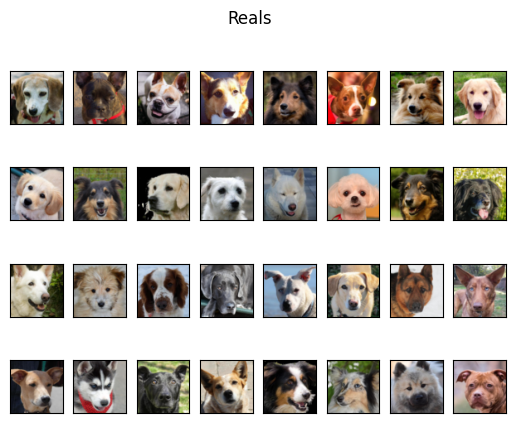

In [189]:
batch, _ = next(iter(train_dataloader))

imgs = []
for id, img in enumerate(batch):
  imgs.append(np.array(img.permute(1,2,0)))

fig = plt.figure(figsize=(8,6))
fig, axs = plt.subplots(4,8)
for i, img in enumerate(imgs):
  col = i % 8
  axs[i//8, col].imshow(img)
  axs[i//8, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.suptitle("Reals")
plt.show()

## Model Arch.


### Generator

In [190]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    nz = CONFIG['nz']
    ngf = CONFIG['ngf']
    nc = CONFIG['nc']

    self.model = nn.Sequential(
        # input is Z, going into a convolution
        nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(True),

        # state size. ``(ngf*8) x 4 x 4``
        nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(True),

        # state size. ``(ngf*4) x 8 x 8``
        nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(True),

        # state size. ``(ngf*2) x 16 x 16``
        nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),

        # state size. ``(ngf) x 32 x 32``
        nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
        nn.Tanh()
        # state size. ``(nc) x 64 x 64``
      )

  def forward(self, input):
    return self.model(input)

In [191]:
from torchvision import models
from torchsummary import summary

In [192]:
g = Generator().to(device)
summary(g, (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

### Discriminator

In [193]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        nc = CONFIG['nc']
        ndf= CONFIG['ndf']

        # TODO: Add drop-out layer for another experiment

        self.model = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input)

In [194]:
d = Discriminator().to(device)
summary(d, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

### Spectral Discriminator

It is important note that spectral norm does not eliminate the need for batch norm. Spectral norm affects the weights of each layer, while batch norm affects the activations of each layer.

In [195]:
class Spectral_Discriminator(nn.Module):
  """
  Claim:
    Spectral Norm stabilizes training

  Support:
    https://arxiv.org/abs/1802.05957
  """
  def __init__(self):
    super(Spectral_Discriminator, self).__init__()

    nc = CONFIG['nc']
    ndf= CONFIG['ndf']

    self.model = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.utils.spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.utils.spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.utils.spectral_norm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

  def forward(self, input):
    return self.model(input)

In [196]:
torch.backends.cudnn.deterministic = False
torch.use_deterministic_algorithms(False)

In [197]:
spd = Spectral_Discriminator().to(device)
summary(spd, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

### Gen+Mapping+AdaIN

In [198]:
class MappingNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    nz = CONFIG['nz']

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(nz,nz)
    self.act = nn.LeakyReLU(negative_slope=0.2, inplace=True)

  def forward(self, z):
    z = F.normalize(z, dim=1)
    z = self.flatten(z)
    # print(z.shape)
    z1 = self.act(self.linear(z))
    z2 = self.act(self.linear(z1))
    z3 = self.act(self.linear(z2))
    w = self.act(self.linear(z3))

    # To sample ws for W-space exploration
    # print("w:", w)

    return w

In [199]:
class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
      super().__init__()
      self.instance_norm = nn.InstanceNorm2d(channels)
      self.style_scale   = nn.Linear(w_dim, channels)
      self.style_bias    = nn.Linear(w_dim, channels)
      self.flatten       = nn.Flatten()

    def forward(self,x,w):
      w = self.flatten(w)
      # print("x:",x.shape, "w_flatten:", w.shape)
      x = self.instance_norm(x)
      # print("after instance norm, x:",x.shape)

      style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
      # print("style_scale.shape:", style_scale.shape)
      style_bias  = self.style_bias(w).unsqueeze(2).unsqueeze(3)
      # print("style_bias.shape:", style_bias.shape)
      return style_scale * x + style_bias

In [200]:
class Generator_Mapper_AdaIN(nn.Module):
    def __init__(self):
        super(Generator_Mapper_AdaIN, self).__init__()

        nz = CONFIG['nz']
        ngf = CONFIG['ngf']
        nc = CONFIG['nc']

        self.starting_const = nn.Parameter(torch.randn(1, nz, 1, 1))

        self.mapper = MappingNetwork()
        self.act = nn.ReLU(inplace=True)

        # L1
        # state size. ``(ngf*8) x 4 x 4``
        self.conv_l1 = nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False)
        self.ada_l1 = AdaIN(ngf * 8, nz)

        # L2
        # state size. ``(ngf*4) x 8 x 8``
        self.conv_l2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.ada_l2 = AdaIN(ngf * 4, nz)

        # L3
        # state size. ``(ngf*2) x 16 x 16``
        self.conv_l3 = nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.ada_l3 = AdaIN(ngf * 2, nz)

        # L4
        # state size. ``(ngf) x 32 x 32``
        self.conv_l4 = nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False)
        self.ada_l4 = AdaIN(ngf, nz)

        # L5
        # state size. ``(nc) x 64 x 64``
        self.conv_l5 = nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False)
        self.last_layer_act = nn.Tanh()


    def forward(self, input_noise):
      w = self.mapper(input_noise)
      w = w[:, :, None, None]

      x = self.act(self.ada_l1(self.conv_l1(self.starting_const), w))
      x = self.act(self.ada_l2(self.conv_l2(x), w))
      x = self.act(self.ada_l3(self.conv_l3(x), w))
      x = self.act(self.ada_l4(self.conv_l4(x), w))
      x = self.last_layer_act(self.conv_l5(x))
      return x

In [201]:
g_map_ada = Generator_Mapper_AdaIN().to(device)
summary(g_map_ada, (100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 100]               0
            Linear-2                  [-1, 100]          10,100
         LeakyReLU-3                  [-1, 100]               0
            Linear-4                  [-1, 100]          10,100
         LeakyReLU-5                  [-1, 100]               0
            Linear-6                  [-1, 100]          10,100
         LeakyReLU-7                  [-1, 100]               0
            Linear-8                  [-1, 100]          10,100
         LeakyReLU-9                  [-1, 100]               0
   MappingNetwork-10                  [-1, 100]               0
  ConvTranspose2d-11            [-1, 512, 4, 4]         819,200
          Flatten-12                  [-1, 100]               0
   InstanceNorm2d-13            [-1, 512, 4, 4]               0
           Linear-14                  [

## Lightning Recipe for training & testing

In [202]:
class LIT_DCGAN(pl.LightningModule):

  def __init__(self,
               discriminator_model,
               generator_model,
               latent_dim: int = 100,
               lr: float = 0.003,
               b1: float = 0.5,
               b2: float = 0.999,
               disc_steps: int = 1):

    super().__init__()
    self.save_hyperparameters(ignore=[discriminator_model, generator_model])
    self.automatic_optimization = False

    self.discriminator = discriminator_model
    self.generator = generator_model
    # self.fid = FrechetInceptionDistance(feature=64)
    # self.fid_lst = []
    self.validation_z = torch.randn(8, self.hparams.latent_dim)


  def configure_optimizers(self):
    lr = self.hparams.lr
    b1 = self.hparams.b1
    b2 = self.hparams.b2

    #---------------------------
    # Exp-2-3.1
    # optim_g = torch.optim.RMSprop(self.generator.parameters(), lr=lr)
    # optim_d = torch.optim.RMSprop(self.discriminator.parameters(), lr=lr)

    # # Exp-2-3.2
    # optim_g = torch.optim.SGD(self.generator.parameters(), lr=lr, momentum=0.9, nesterov=True)
    # optim_d = torch.optim.SGD(self.discriminator.parameters(), lr=lr, momentum=0.9, nesterov=True)

    # # Exp-2-3.3
    # optim_g = torch.optim.SGD(self.generator.parameters(), lr=lr, nesterov=False)
    # optim_d = torch.optim.SGD(self.discriminator.parameters(), lr=lr, nesterov=False)

    #----------------------------

    optim_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1,b2))
    optim_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1,b2))

    # sch_g = torch.optim.lr_scheduler.CosineAnnealingLR(optim_g,
    # T_max=CONFIG['NUM_EPOCHS']*len(train_dataloader)/CONFIG['BATCH_SIZE],
    #  eta_min=CONFIG['min_lr'])

    # sch_d = torch.optim.lr_scheduler.CosineAnnealingLR(optim_d,
    # T_max=CONFIG['NUM_EPOCHS']*len(train_dataloader)/CONFIG['BATCH_SIZE],
    #  eta_min=CONFIG['min_lr'])
    #---------------------------

    # return [optim_g, optim_d], [sch_g, sch_d]
    return [optim_g, optim_d], []


  def forward(self, z):
    return self.generator(z)


  def adv_loss(self, prob, target):
    loss = F.binary_cross_entropy(prob.to(device), target.to(device))
    return loss


  def linear_interpolate(self, code1, code2, alpha):
    return code1 * alpha + code2 * (1 - alpha)


  # def test_step(self, batch, batch_idx): # Use for Exploring the latent space
  #   imgs, _ = batch
  #   z1 = torch.randn(1, self.hparams.latent_dim, 1, 1) # 1 x Z_d x 1 x 1
  #   z1 = z1.type_as(imgs)

  #   z2 = torch.randn(1, self.hparams.latent_dim, 1, 1) # 1 x Z_d x 1 x 1
  #   z2 = z2.type_as(imgs)

  #   interp_imgs = []
  #   for i in tqdm(range(1001)):
  #     alpha = i/1000.
  #     z_interp = self.linear_interpolate(z1, z2, alpha)
  #     gen_img = self.generator(z_interp)
  #     interp_imgs.append(gen_img)

  #     save_img = gen_img.cpu().squeeze(0).numpy()
  #     save_img_hwc = np.reshape(save_img, (64,64,3))
  #     status = cv.imwrite(f"/content/interp/z_{i+1}.png", save_img_hwc)
  #     # print(status, save_img_hwc.shape)

  #   # for i in range(len(gen_img)):
  #   #   wandb_logger.log_image(key="Interpolation",
  #   #                          images=[gen_img[i]])

  #   # self.logger.experiment.log({f"Gen_Image {alpha}":[wandb.Image(gen_img.cpu(), caption=f"Interpolation [alpha={alpha}]")]})

  #   return z1, z2, interp_imgs


  def validation_step(self, batch, batch_idx):
    imgs, _ = batch

    z = torch.randn(imgs.shape[0], self.hparams.latent_dim, 1, 1) # N x Z_d x 1 x 1
    z = z.type_as(imgs)
    fake_imgs = self.generator(z)

    real_arr = torch.ones(imgs.size(0), 1, 1, 1).to(device)
    fake_arr = torch.zeros(imgs.size(0), 1, 1, 1).to(device)

    g_loss = self.adv_loss(self.discriminator(fake_imgs), real_arr) # make fakes as close to reals

    real_D_outs = self.discriminator(imgs)
    fake_D_outs = self.discriminator(fake_imgs)
    d_loss = (self.adv_loss(real_D_outs, real_arr) + self.adv_loss(fake_D_outs, fake_arr)) / 2

    # Disc Acc:
    correct_real = sum(i > 0.5 for i in real_D_outs)
    total_real = len(real_D_outs)

    correct_fake = sum(i < 0.5 for i in fake_D_outs)
    total_fake = len(fake_D_outs)

    D_accuracy = (correct_real + correct_fake) / (total_real + total_fake)

    # self.fid.update(imgs, real=True)
    # self.fid.update(fake_imgs, real=False)
    # self.fid_lst.append(self.fid.compute())
    # self.fid.reset()

    logs = {'val_g_loss': g_loss, 'val_d_loss': d_loss}
    self.log_dict({'val_g_loss': g_loss, 'val_d_loss': d_loss, 'val_d_accuracy': D_accuracy},
                  on_step=True,
                  on_epoch=True,
                  prog_bar=True,
                  logger=True)

    cpu_fake_imgs = fake_imgs.detach().cpu().numpy()
    gen_1_id = np.random.randint(0,cpu_fake_imgs.shape[0])

    # self.logger.experiment.log({"Gen_Image_1 (during val step)":[wandb.Image(fake_imgs[gen_1_id].cpu(), caption="Generated 1 (val_step)")]})


  def training_step(self, batch, batch_idx):
    imgs, _ = batch
    # print(f"{batch_idx}:: imgs.shape =",imgs.shape)

    opt_g, opt_d = self.optimizers()
    # sch_g, sch_d = self.lr_schedulers()

    z = torch.randn(imgs.shape[0], self.hparams.latent_dim, 1, 1) # N x Z_d x 1 x 1
    z = z.type_as(imgs)

    fake_arr = torch.zeros(imgs.size(0), 1, 1, 1).to(device) # N: 0s
    real_arr = torch.ones(imgs.size(0), 1, 1, 1).to(device) # N: 1s
    # print(f"Disc out shape:", self.discriminator(self(z)).shape)
    # Train G:
    self.toggle_optimizer(opt_g)

    # Generator loss:
    fake_imgs = self.generator(z)
    g_loss = self.adv_loss(self.discriminator(fake_imgs), real_arr) # Fooling the Disc: How Real is the fake output?

    # Grad step:
    # self.log("g_loss", g_loss, prog_bar=True)
    self.manual_backward(g_loss)
    opt_g.step()
    opt_g.zero_grad()

    # Scheduler moves ahead after every epoch
    # if (batch_idx + 1) % CONFIG['BATCH_SIZE'] == 0:
    #     sch_g.step()

    self.untoggle_optimizer(opt_g)

    # Train Discriminator
    self.toggle_optimizer(opt_d)

    # Experimental evidence: #disc_steps is kept to 1

    for i in range(self.hparams.disc_steps):
      # Discriminator loss:
      real_D_outs = self.discriminator(imgs)
      d_loss_real = self.adv_loss(real_D_outs, real_arr)

      fake_D_outs = self.discriminator(self.generator(z))
      d_loss_fake = self.adv_loss(fake_D_outs, fake_arr)

      d_loss = (d_loss_fake + d_loss_real) / 2

      # self.log("d_loss", d_loss, prog_bar=True)
      self.manual_backward(d_loss)
      opt_d.step()
      opt_d.zero_grad()

      # Disc Acc:
      correct_real = sum(i > 0.5 for i in real_D_outs)
      total_real = len(real_D_outs)

      correct_fake = sum(i < 0.5 for i in fake_D_outs)
      total_fake = len(fake_D_outs)

      D_accuracy = (correct_real + correct_fake) / (total_real + total_fake)

      # self.log("d_acc", D_accuracy, prog_bar=True)

    # Scheduler moves ahead after every epoch
    # if (batch_idx + 1) % CONFIG['BATCH_SIZE'] == 0:
    #   sch_d.step()

    self.untoggle_optimizer(opt_d)

    cpu_fake_imgs = fake_imgs.detach().cpu().numpy()
    gen_id = np.random.randint(0,cpu_fake_imgs.shape[0])

    # self.logger.experiment.log({"Gen_Image_1 (during training)":[wandb.Image(fake_imgs[gen_id].cpu(), caption="Generated (train_step)")]})

    self.log_dict({"g_loss": g_loss, "d_loss": d_loss, "d_acc": D_accuracy},
                  on_step=True,
                  on_epoch=True,
                  prog_bar=True,
                  logger=True)

    # def on_epoch_end(self):
    #   z = self.validation_z.to(self.device)

    #   # log sampled images
    #   sample_imgs = self.generator(z)
    #   grid = torchvision.utils.make_grid(sample_imgs)
    #   self.logger.experiment.add_image(f'Unseen generated imgs after epoch {self.current_epoch}:', grid, self.current_epoch)


In [203]:
sample_img, sample_target = next(iter(train_dataloader))
sample_img.shape, sample_target.size()

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [204]:
!pip install -Uqq pytorch-fid

In [205]:
dcgan = LIT_DCGAN(
      discriminator_model = Spectral_Discriminator(),
      generator_model = Generator_Mapper_AdaIN(),
      latent_dim = CONFIG['nz'],
      lr=CONFIG['lr'],
      b1=CONFIG['b1'],
      b2=CONFIG['b2'],
      disc_steps=CONFIG['disc_steps']
    )
summary = ModelSummary(dcgan, max_depth=-1)
print(summary)

   | Name                           | Type                   | Params
---------------------------------------------------------------------------
0  | discriminator                  | Discriminator          | 2.8 M 
1  | discriminator.model            | Sequential             | 2.8 M 
2  | discriminator.model.0          | Conv2d                 | 3.1 K 
3  | discriminator.model.1          | LeakyReLU              | 0     
4  | discriminator.model.2          | Conv2d                 | 131 K 
5  | discriminator.model.3          | BatchNorm2d            | 256   
6  | discriminator.model.4          | LeakyReLU              | 0     
7  | discriminator.model.5          | Conv2d                 | 524 K 
8  | discriminator.model.6          | BatchNorm2d            | 512   
9  | discriminator.model.7          | LeakyReLU              | 0     
10 | discriminator.model.8          | Conv2d                 | 2.1 M 
11 | discriminator.model.9          | BatchNorm2d            | 1.0 K 
12 | discrimin

## Trainer (+ callbacks)

In [206]:
from pytorch_lightning import Callback
from lightning.pytorch.callbacks import DeviceStatsMonitor, TQDMProgressBar, ModelCheckpoint, EarlyStopping, LearningRateMonitor

# Checkpoint
checkpoint_callback = ModelCheckpoint(dirpath=CONFIG['checkpoint_path'],
                                      filename='{epoch}-{val_g_loss:.3f}',
                                      monitor='val_g_loss',
                                      save_top_k=-1,
                                      save_last=True,
                                      save_weights_only=True,
                                      verbose=True,
                                      mode='min')

# Exp2: Learning Rate Monitor
lr_monitor = LearningRateMonitor(logging_interval='step', log_momentum=True)

# Earlystopping
# earlystopping = EarlyStopping(monitor='val_d_acc', patience=3, mode='min')

In [207]:
wandb_logger = WandbLogger(project='M4-DCGAN',
                           name='exp-6_100%',
                           config=CONFIG,
                           job_type='train_val',
                           log_model="all")

In [208]:
# train model

trainer = pl.Trainer(fast_dev_run=False,    # For debugging purposes
                     log_every_n_steps=1,   # set the logging frequency
                     accelerator='auto',    # Precedence: tpu > gpu >> cpu
                     devices="auto",        # all
                     max_epochs=CONFIG['NUM_EPOCHS'], # number of epochs
                     callbacks=[TQDMProgressBar(refresh_rate=25),
                                checkpoint_callback,
                                lr_monitor],
                     logger=wandb_logger,    # wandb <3
                     )

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


## Training & Validation

In [209]:
!rm -rf checkpoints

In [210]:
# Train model:
trainer.fit(dcgan, train_dataloader, val_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type                   | Params
---------------------------------------------------------
0 | discriminator | Discriminator          | 2.8 M 
1 | generator     | Generator_Mapper_AdaIN | 3.8 M 
---------------------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Total params
26.178    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type                   | Params
---------------------------------------------------------
0 | discriminator | Discriminator          | 2.8 M 
1 | generator     | Generator_Mapper_AdaIN | 3.8 M 
---------------------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Total params
26.178    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 298: 'val_g_loss' reached 1.68506 (best 1.68506), saving model to '/content/checkpoints/epoch=0-val_g_loss=1.685.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 298: 'val_g_loss' reached 1.68506 (best 1.68506), saving model to '/content/checkpoints/epoch=0-val_g_loss=1.685.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 596: 'val_g_loss' reached 1.76323 (best 1.68506), saving model to '/content/checkpoints/epoch=1-val_g_loss=1.763.ckpt' as top 2
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 596: 'val_g_loss' reached 1.76323 (best 1.68506), saving model to '/content/checkpoints/epoch=1-val_g_loss=1.763.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 894: 'val_g_loss' reached 3.49970 (best 1.68506), saving model to '/content/checkpoints/epoch=2-val_g_loss=3.500.ckpt' as top 3
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 894: 'val_g_loss' reached 3.49970 (best 1.68506), saving model to '/content/checkpoints/epoch=2-val_g_loss=3.500.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 1192: 'val_g_loss' reached 10.50286 (best 1.68506), saving model to '/content/checkpoints/epoch=3-val_g_loss=10.503.ckpt' as top 4
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 1192: 'val_g_loss' reached 10.50286 (best 1.68506), saving model to '/content/checkpoints/epoch=3-val_g_loss=10.503.ckpt' as top 4


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 1490: 'val_g_loss' reached 3.80217 (best 1.68506), saving model to '/content/checkpoints/epoch=4-val_g_loss=3.802.ckpt' as top 5
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 1490: 'val_g_loss' reached 3.80217 (best 1.68506), saving model to '/content/checkpoints/epoch=4-val_g_loss=3.802.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 1788: 'val_g_loss' reached 5.47602 (best 1.68506), saving model to '/content/checkpoints/epoch=5-val_g_loss=5.476.ckpt' as top 6
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 1788: 'val_g_loss' reached 5.47602 (best 1.68506), saving model to '/content/checkpoints/epoch=5-val_g_loss=5.476.ckpt' as top 6


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 2086: 'val_g_loss' reached 2.91321 (best 1.68506), saving model to '/content/checkpoints/epoch=6-val_g_loss=2.913.ckpt' as top 7
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 2086: 'val_g_loss' reached 2.91321 (best 1.68506), saving model to '/content/checkpoints/epoch=6-val_g_loss=2.913.ckpt' as top 7


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 2384: 'val_g_loss' reached 4.63155 (best 1.68506), saving model to '/content/checkpoints/epoch=7-val_g_loss=4.632.ckpt' as top 8
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 2384: 'val_g_loss' reached 4.63155 (best 1.68506), saving model to '/content/checkpoints/epoch=7-val_g_loss=4.632.ckpt' as top 8


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 2682: 'val_g_loss' reached 2.77415 (best 1.68506), saving model to '/content/checkpoints/epoch=8-val_g_loss=2.774.ckpt' as top 9
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 2682: 'val_g_loss' reached 2.77415 (best 1.68506), saving model to '/content/checkpoints/epoch=8-val_g_loss=2.774.ckpt' as top 9


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 2980: 'val_g_loss' reached 3.89683 (best 1.68506), saving model to '/content/checkpoints/epoch=9-val_g_loss=3.897.ckpt' as top 10
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 2980: 'val_g_loss' reached 3.89683 (best 1.68506), saving model to '/content/checkpoints/epoch=9-val_g_loss=3.897.ckpt' as top 10


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 10, global step 3278: 'val_g_loss' reached 2.47927 (best 1.68506), saving model to '/content/checkpoints/epoch=10-val_g_loss=2.479.ckpt' as top 11
INFO:lightning.pytorch.utilities.rank_zero:Epoch 10, global step 3278: 'val_g_loss' reached 2.47927 (best 1.68506), saving model to '/content/checkpoints/epoch=10-val_g_loss=2.479.ckpt' as top 11


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 11, global step 3576: 'val_g_loss' reached 3.50592 (best 1.68506), saving model to '/content/checkpoints/epoch=11-val_g_loss=3.506.ckpt' as top 12
INFO:lightning.pytorch.utilities.rank_zero:Epoch 11, global step 3576: 'val_g_loss' reached 3.50592 (best 1.68506), saving model to '/content/checkpoints/epoch=11-val_g_loss=3.506.ckpt' as top 12


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 12, global step 3874: 'val_g_loss' reached 2.15707 (best 1.68506), saving model to '/content/checkpoints/epoch=12-val_g_loss=2.157.ckpt' as top 13
INFO:lightning.pytorch.utilities.rank_zero:Epoch 12, global step 3874: 'val_g_loss' reached 2.15707 (best 1.68506), saving model to '/content/checkpoints/epoch=12-val_g_loss=2.157.ckpt' as top 13


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 13, global step 4172: 'val_g_loss' reached 0.86126 (best 0.86126), saving model to '/content/checkpoints/epoch=13-val_g_loss=0.861.ckpt' as top 14
INFO:lightning.pytorch.utilities.rank_zero:Epoch 13, global step 4172: 'val_g_loss' reached 0.86126 (best 0.86126), saving model to '/content/checkpoints/epoch=13-val_g_loss=0.861.ckpt' as top 14


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 14, global step 4470: 'val_g_loss' reached 3.32843 (best 0.86126), saving model to '/content/checkpoints/epoch=14-val_g_loss=3.328.ckpt' as top 15
INFO:lightning.pytorch.utilities.rank_zero:Epoch 14, global step 4470: 'val_g_loss' reached 3.32843 (best 0.86126), saving model to '/content/checkpoints/epoch=14-val_g_loss=3.328.ckpt' as top 15


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 15, global step 4768: 'val_g_loss' reached 1.25969 (best 0.86126), saving model to '/content/checkpoints/epoch=15-val_g_loss=1.260.ckpt' as top 16
INFO:lightning.pytorch.utilities.rank_zero:Epoch 15, global step 4768: 'val_g_loss' reached 1.25969 (best 0.86126), saving model to '/content/checkpoints/epoch=15-val_g_loss=1.260.ckpt' as top 16


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 16, global step 5066: 'val_g_loss' reached 0.63284 (best 0.63284), saving model to '/content/checkpoints/epoch=16-val_g_loss=0.633.ckpt' as top 17
INFO:lightning.pytorch.utilities.rank_zero:Epoch 16, global step 5066: 'val_g_loss' reached 0.63284 (best 0.63284), saving model to '/content/checkpoints/epoch=16-val_g_loss=0.633.ckpt' as top 17


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 17, global step 5364: 'val_g_loss' reached 1.14743 (best 0.63284), saving model to '/content/checkpoints/epoch=17-val_g_loss=1.147.ckpt' as top 18
INFO:lightning.pytorch.utilities.rank_zero:Epoch 17, global step 5364: 'val_g_loss' reached 1.14743 (best 0.63284), saving model to '/content/checkpoints/epoch=17-val_g_loss=1.147.ckpt' as top 18


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 18, global step 5662: 'val_g_loss' reached 1.63507 (best 0.63284), saving model to '/content/checkpoints/epoch=18-val_g_loss=1.635.ckpt' as top 19
INFO:lightning.pytorch.utilities.rank_zero:Epoch 18, global step 5662: 'val_g_loss' reached 1.63507 (best 0.63284), saving model to '/content/checkpoints/epoch=18-val_g_loss=1.635.ckpt' as top 19


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 19, global step 5960: 'val_g_loss' reached 1.91395 (best 0.63284), saving model to '/content/checkpoints/epoch=19-val_g_loss=1.914.ckpt' as top 20
INFO:lightning.pytorch.utilities.rank_zero:Epoch 19, global step 5960: 'val_g_loss' reached 1.91395 (best 0.63284), saving model to '/content/checkpoints/epoch=19-val_g_loss=1.914.ckpt' as top 20
INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [211]:
wandb.finish()

d_acc_epoch,█▄▇██▅▂▅▂▄▅▅▄▇▆▁▃▅▆▃
d_acc_step,▇▃▅▆▅▆▆▁▆▆▆▂▆▆▃▇▂▄▄▇▇█▃▂▇▆▃▆▇▅▅▂▄▃▅▄▅▇▆▃
d_loss_epoch,▅▅▂▁▂▄▆▃▆▃▃▂▃▁▁█▃▁▂▃
d_loss_step,▁▇▄▃▄▃▄█▃▃▄▆▄▃▆▂█▆▅▄▃▂█▆▃▃▅▃▃▅▃█▄▅▄▅▃▃▄▅
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
g_loss_epoch,█▁▂▂▂▃▂▂▂▂▃▂▂▂▂▁▁▁▁▁
g_loss_step,█▃▁▂▃▃▃▁▃▂▃▁▃▂▃▃▁▃▃▂▃▃▄▁▂▂▂▂▂▂▃▁▂▂▂▃▁▂▃▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-1-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


## Experiment 4 / Testing

#### Loading: last checkpoint

In [212]:
model_fid = LIT_DCGAN.load_from_checkpoint("/content/checkpoints/last.ckpt", map_location=torch.device('cpu'))
summary = ModelSummary(model_fid, max_depth=-1)
print(summary)

   | Name                           | Type                   | Params
---------------------------------------------------------------------------
0  | discriminator                  | Discriminator          | 2.8 M 
1  | discriminator.model            | Sequential             | 2.8 M 
2  | discriminator.model.0          | Conv2d                 | 3.1 K 
3  | discriminator.model.1          | LeakyReLU              | 0     
4  | discriminator.model.2          | Conv2d                 | 131 K 
5  | discriminator.model.3          | BatchNorm2d            | 256   
6  | discriminator.model.4          | LeakyReLU              | 0     
7  | discriminator.model.5          | Conv2d                 | 524 K 
8  | discriminator.model.6          | BatchNorm2d            | 512   
9  | discriminator.model.7          | LeakyReLU              | 0     
10 | discriminator.model.8          | Conv2d                 | 2.1 M 
11 | discriminator.model.9          | BatchNorm2d            | 1.0 K 
12 | discrimin

In [213]:
!rm -rf out_gen
!mkdir out_gen

In [214]:
for i in range(len(os.listdir("/content/data/afhq/train/dog/"))):
  doggo = model_fid.generator(torch.randn(1,100,1,1)).squeeze()
  pil_doggo = torchvision.transforms.ToPILImage()(doggo)
  pil_doggo.save(f"/content/out_gen/img_{i}.png","PNG")

#### Alt FID

In [215]:
import numpy as np
from scipy import linalg
import warnings

# NOTE: more forgiving FID. Use if imaginary component too high......
def fid(mn1, cov1, mn2, cov2, eps=1e-6):
    mn1 = np.atleast_1d(mn1)
    mn2 = np.atleast_1d(mn2)

    cov1 = np.atleast_2d(cov1)
    cov2 = np.atleast_2d(cov2)

    diff = mn1 - mn2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(cov1.dot(cov2), disp=False)
    if not np.isfinite(covmean).all():
        warnings.warn(("fid() got singular product; adding {} to diagonal of "
                       "cov estimates").format(eps))
        offset = np.eye(d) * eps
        covmean = linalg.sqrtm((cov1 + offset).dot(cov2 + offset))

    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(cov1) + np.trace(cov2) - 2 * tr_covmean

In [216]:
!python -m pytorch_fid --device cuda:0 /content/data/afhq/val/dog /content/out_gen/

100% 95/95 [00:38<00:00,  2.47it/s]
100% 95/95 [00:19<00:00,  4.99it/s]
FID:  285.57930748763374


### Inception Score

In [ ]:
from torch.autograd import Variable
from torchvision.models.inception import inception_v3

import numpy as np
from scipy.stats import entropy


def inception_score(imgs, cuda=True, batch_size=32, resize=True, splits=1):
    """Computes the inception score of the generated images imgs

    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

In [ ]:
doggo = model_fid.generator(torch.randn(1,100,1,1)).squeeze()

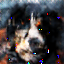

In [ ]:
pil_doggo = torchvision.transforms.ToPILImage()(doggo)
display(pil_doggo)

In [ ]:
!rm -rf interp
!mkdir interp

In [ ]:
def linear_interpolate(code1, code2, alpha):
    return code1 * alpha + code2 * (1 - alpha)

#### z-space Interpolation

In [ ]:
# trainer_interp = pl.Trainer(fast_dev_run=False,    # For debugging purposes
#                      log_every_n_steps=1,   # set the logging frequency
#                      accelerator='auto',    # Precedence: tpu > gpu >> cpu
#                      devices="auto",        # all
#                      max_epochs=CONFIG['NUM_EPOCHS'], # number of epochs
#                      deterministic=True,    # keep it deterministic
#                      callbacks=[TQDMProgressBar(refresh_rate=25),
#                                 checkpoint_callback,
#                                 lr_monitor],
#                      logger=wandb_logger,    # wandb <3
#                      )

# gen_imgs, z1, z2 = trainer_interp.test(model_interp, train_dataloader)

model_fid.eval()

with torch.inference_mode():
    z1 = torch.randn(1, 100, 1, 1) # 1 x Z_d x 1 x 1
    z2 = torch.randn(1, 100, 1, 1) # 1 x Z_d x 1 x 1
    # print(z1, z2)

    gen_img_arr = []
    for i in tqdm(range(1001)):
      alpha = i/1000.0
      z_interp = linear_interpolate(z1, z2, alpha)

      gen_img = model_fid.generator(z_interp).squeeze()
      pil_gen_img = torchvision.transforms.ToPILImage()(gen_img)

      gen_img_arr.append(pil_gen_img)

      num = str(i).zfill(5)
      pil_gen_img.save(f"/content/interp/z_{num}.png")

  0%|          | 0/1001 [00:00<?, ?it/s]

In [ ]:
def make_latent_interp_video(gen_imgs):
  gen_imgs[0].save("out_10fps_wspace_1May.gif", save_all=True, append_images=gen_imgs, duration=100, loop=0)

## Baseline 1: DCGAN

In [20]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.0005

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5
beta2 = 0.999

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [21]:
# Generator Code
class DCGAN_Generator(nn.Module):
    def __init__(self, ngpu=1):
        super(DCGAN_Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [22]:
class DCGAN_Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(DCGAN_Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [23]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [81]:
# Create the generator
netG = DCGAN_Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)
from torchsummary import summary
summary(netG, (100,1,1))

DCGAN_Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()


In [82]:
# Create the Discriminator
netD = DCGAN_Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)
summary(netD, (3,64,64))

DCGAN_Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
------------------------

In [83]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [85]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        # if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_dataloader)-1)):
        #     with torch.no_grad():
        #         fake = netG(fixed_noise).detach().cpu()
        #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    torch.save(netG.state_dict(), f"/content/DCGAN_ckpt/{epoch}.ckpt")

Starting Training Loop...
[0/20][0/149]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[0/20][50/149]	Loss_D: 100.0001	Loss_G: 0.0000	D(x): 0.9999	D(G(z)): 1.0000 / 1.0000
[0/20][100/149]	Loss_D: 100.0002	Loss_G: 0.0000	D(x): 0.9998	D(G(z)): 1.0000 / 1.0000
[1/20][0/149]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[1/20][50/149]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[1/20][100/149]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[2/20][0/149]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[2/20][50/149]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[2/20][100/149]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[3/20][0/149]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[3/20][50/149]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[3/20][100/149]	Loss_D: 100.0000	Loss_G:

In [29]:
# To Do: compute FID for dcgan; ckpyt saved on desktop
PATH = "/content/dcgan_19.ckpt"
checkpoint = torch.load(PATH)
dc_gen = DCGAN_Generator()
dc_gen.load_state_dict(checkpoint)

from tqdm.notebook import tqdm

for i in tqdm(range(len(os.listdir("/content/data/afhq/train/dog")))):
  noise = torch.randn(1, nz, 1, 1)
  doggo = dc_gen(noise).squeeze()
  pil_doggo = torchvision.transforms.ToPILImage()(doggo)
  pil_doggo.save(f"/content/out_gen/img_{i}.png","PNG")

  0%|          | 0/4739 [00:00<?, ?it/s]

In [31]:
!pip install -Uqq pytorch-fid
!python -m pytorch_fid --device cuda:0 /content/data/afhq/val/dog /content/out_gen/

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:00<00:00, 313MB/s]
100% 95/95 [00:38<00:00,  2.44it/s]
100% 95/95 [00:19<00:00,  4.82it/s]
FID:  424.51295358268817
